## Cityscapes dataset Assembling

The <a href="https://www.cityscapes-dataset.com">Cityscapes Dataset</a> focuses on semantic understanding of urban street scenes"

Contains more than 5,000 pictures with fine-grained semantic labels / 20,000 pictures with coarser annotations, shot from cars driving around ~50 cities in Germany

In [1]:
# Import libs

import os
import numpy as np
import tensorflow as tf
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import functools

#support utils
from utils.plot_utils import plot_image_grid
from utils import labels as cityscapes_labels


seed = 42 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

### Обзор содержания датасета

In [3]:
# !pip install ./cityscapesScripts # позволяет использовать дополнительные команды из пакета 

# Преобразует json аннотации в формат полигональный формат png изображения с размеченными IDs, 
# пиксели энкодятся по "train IDs", объявленные  в `labels.py`
# !csCreateTrainIdLabelImgs # требует наличие указателя на папку датасета в переменных среды

In [2]:
table_format = '| {0: >2} | {1: <20} | {2: >7} | {3: >15} | {4: <12} | {5: >5} |'

header = table_format.format("id", "name", "trainId", "color", "category", "catId")
print(header)
print("-" * len(header))
for label in cityscapes_labels.labels:
    print(table_format.format(
        label.id, label.name, label.trainId, str(label.color), label.category, label.categoryId))

| id | name                 | trainId |           color | category     | catId |
--------------------------------------------------------------------------------
|  0 | unlabeled            |     255 |       (0, 0, 0) | void         |     0 |
|  1 | ego vehicle          |     255 |       (0, 0, 0) | void         |     0 |
|  2 | rectification border |     255 |       (0, 0, 0) | void         |     0 |
|  3 | out of roi           |     255 |       (0, 0, 0) | void         |     0 |
|  4 | static               |     255 |       (0, 0, 0) | void         |     0 |
|  5 | dynamic              |     255 |    (111, 74, 0) | void         |     0 |
|  6 | ground               |     255 |     (81, 0, 81) | void         |     0 |
|  7 | road                 |       0 |  (128, 64, 128) | flat         |     1 |
|  8 | sidewalk             |       1 |  (244, 35, 232) | flat         |     1 |
|  9 | parking              |     255 | (250, 170, 160) | flat         |     1 |
| 10 | rail track           

###  Data visualization

In [3]:
# Constants

CITYSCAPES_IGNORE_VALUE = 255 # reduce redundant id's
CITYSCAPES_LABELS = [label for label in cityscapes_labels.labels 
                     if 0 <= label.trainId < CITYSCAPES_IGNORE_VALUE] # labels
CITYSCAPES_COLORS = np.array([label.color for label in CITYSCAPES_LABELS]) # Color list for each remaining classes
CITYSCAPES_FOLDER = os.getenv('CITYSCAPES_DATASET', default=os.path.abspath('data')) # data folder
CITYSCAPES_INT_FILL = 6    # length of Cityscapes image IDs (e.g., "000001")
CITYSCAPES_FILE_TEMPLATE = os.path.join(
    '{root}', '{type}', '{split}', '{city}',
    '{city}_{seq:{filler}>{len_fill}}_{frame:{filler}>{len_fill}}_{type}{type2}{ext}')

In [4]:
CITYSCAPES_LABELS

[Label(name='road', id=7, trainId=0, category='flat', categoryId=1, hasInstances=False, ignoreInEval=False, color=(128, 64, 128)),
 Label(name='sidewalk', id=8, trainId=1, category='flat', categoryId=1, hasInstances=False, ignoreInEval=False, color=(244, 35, 232)),
 Label(name='building', id=11, trainId=2, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(70, 70, 70)),
 Label(name='wall', id=12, trainId=3, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(102, 102, 156)),
 Label(name='fence', id=13, trainId=4, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(190, 153, 153)),
 Label(name='pole', id=17, trainId=5, category='object', categoryId=3, hasInstances=False, ignoreInEval=False, color=(153, 153, 153)),
 Label(name='traffic light', id=19, trainId=6, category='object', categoryId=3, hasInstances=False, ignoreInEval=False, color=(250, 170, 30)),
 Label(name='traffic sign', id=

In [5]:
def get_cityscapes_file_pairs(split='train', city='*', sequence='*', 
                              frame='*', ext='.*', gt_type='labelTrainIds', type='leftImg8bit',
                              root_folder=CITYSCAPES_FOLDER, file_template=CITYSCAPES_FILE_TEMPLATE):
    
    """Function to list all the images and their labels"""
    
    """
    Fetch pairs of filenames for the Cityscapes dataset.
    Note: wildcards accepted for the parameters (e.g. city='*' to return image pairs from every city)
    :param split:           Name of the split to return pairs from ("train", "val", ...)
    :param city:            Name of the city(ies)
    :param sequence:        Name of the video sequence(s)
    :param frame:           Name of the frame
    :param ext:             File extension
    :param gt_type:         Cityscapes GT type
    :param type:            Cityscapes image type
    :param root_folder:     Cityscapes root folder
    :param file_template:   File template to be applied (default corresponds to Cityscapes original format)
    :return:                List of input files, List of corresponding GT files
    """
    
    input_file_template = file_template.format(
        root=root_folder, type=type, type2='', len_fill=1, filler='*',
        split=split, city=city, seq=sequence, frame=frame, ext=ext)
    input_files = glob.glob(input_file_template)
    
    gt_file_template = file_template.format(
        root=root_folder, type='gtFine', type2='_'+gt_type, len_fill=1, filler='*',
        split=split, city=city, seq=sequence, frame=frame, ext=ext)

    gt_files = glob.glob(gt_file_template)
    
    assert(len(input_files) == len(gt_files))
    return sorted(input_files), sorted(gt_files)

In [6]:
train_input_files, train_gt_files = get_cityscapes_file_pairs(
    split='train', type='leftImg8bit_blurred')
val_input_files, val_gt_files = get_cityscapes_file_pairs(
    split='val', type='leftImg8bit_blurred')
print("Cityscapes - Training Dataset : {} images ; {} GTs.".format(
    len(train_input_files), len(train_gt_files)))
print("Cityscapes - Validation Dataset : {} images ; {} GTs.".format(
    len(val_input_files), len(val_gt_files)))

Cityscapes - Training Dataset : 2975 images ; 2975 GTs.
Cityscapes - Validation Dataset : 500 images ; 500 GTs.


In [7]:
train_input_files[0]

'C:\\Users\\Nickel\\1_Py_NoteBooks\\GU_Introduction_To_Deep_Learning\\Cityscapes Object Detection\\data\\leftImg8bit_blurred\\train\\aachen\\aachen_000000_000019_leftImg8bit_blurred.jpg'

In [8]:
def convert_labels_to_colors_numpy(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                                   color_array=CITYSCAPES_COLORS, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Convert label images into color ones for display (for numpy objects).
    :param label:           Label image (numpy array)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_array:     Array mapping labels to colors
    :param ignore_value:    Value of label to be ignored (for one-hotting)
    :return:                Color map
    """

    if one_hot:
        label_shape = label.shape
        label = label.reshape(-1)
        label[label == ignore_value] = num_classes
        label = np.eye(num_classes + 1, dtype=np.int32)[label]
        label = label[..., :num_classes]
    else:
        label_shape = label.shape[:-1]
        label = label.reshape(-1, label.shape[-1])

    colors = np.matmul(label, color_array)

    return colors.reshape(list(label_shape) + [colors.shape[1]])

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


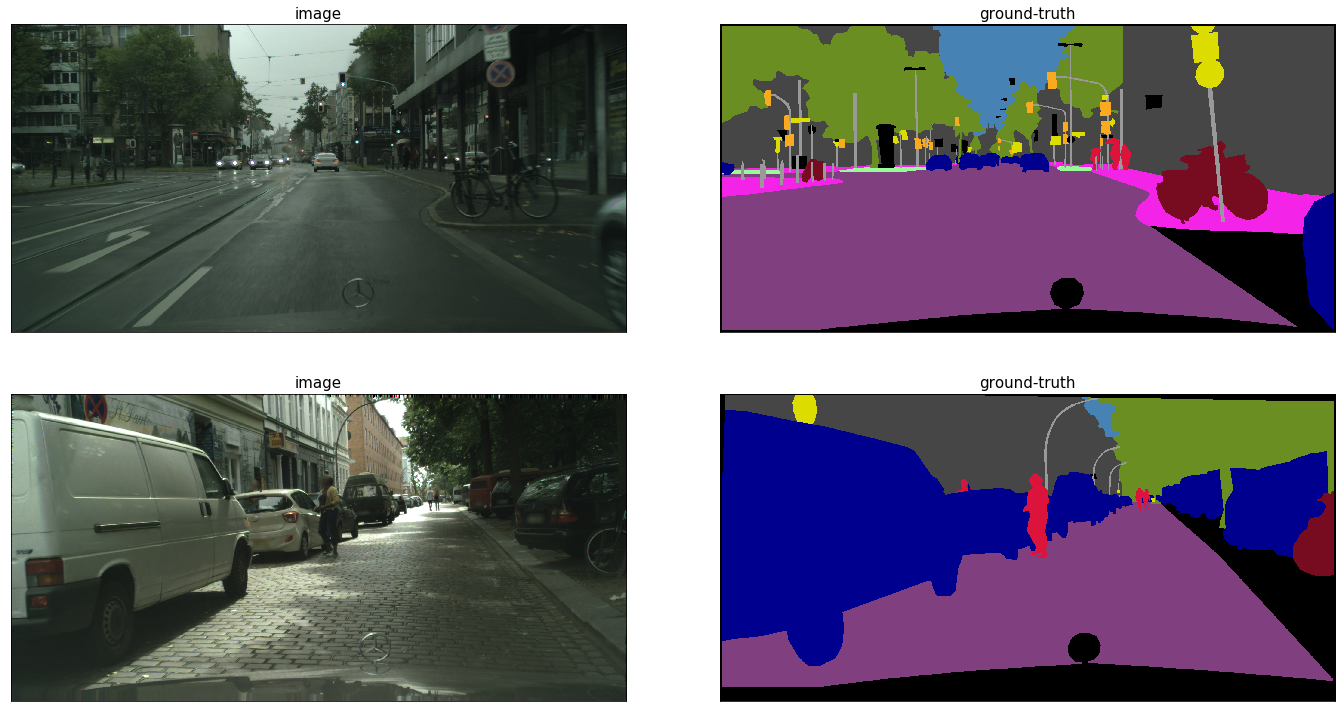

In [9]:
"""Визуализация размеченных данных"""

num_show = 2
np.random.seed(seed)
random_ids = np.random.choice(len(train_input_files), size=num_show)

train_input_files_samples = [train_input_files[i] for i in random_ids]
train_gt_files_samples = [train_gt_files[i] for i in random_ids]

images_samples = [io.imread(file) for file in train_input_files_samples]
gt_samples = [io.imread(file) for file in train_gt_files_samples]
gt_colors = [convert_labels_to_colors_numpy(mask) for mask in gt_samples]
figure = plot_image_grid([images_samples, gt_colors], ["image", "ground-truth"])
figure.show()

## Input pipelines

In [10]:
CITYSCAPES_IMG_RATIO = int(images_samples[0].shape[1]) / int(images_samples[0].shape[0])
print("Cityscape image shape = {} --> ratio = {} (to reshape squared images later)".format(
    images_samples[0].shape, CITYSCAPES_IMG_RATIO))

Cityscape image shape = (1024, 2048, 3) --> ratio = 2.0 (to reshape squared images later)


In [11]:
def parse_function(filenames, resize_to=[226, 226], augment=True):
    
    """
    Parse files into input/label image pair.
    :param filenames:   Dict containing the file(s) (filenames['image'], filenames['label'])
    :param resize_to:   H x W Dimensions to resize the image and label to
    :param augment:     Flag to augment the pair
    :return:            Input tensor, Label tensor
    """

    img_filename, gt_filename = filenames['image'], filenames.get('label', None)

    # Reading the file and returning its content as bytes:
    image_string = tf.io.read_file(img_filename)
    # Decoding into an image:
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    # Converting image to float:
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)

    # Resizing:
    image = tf.image.resize(image, resize_to)

    if gt_filename is not None:
        # Same for GT image:
        gt_string = tf.io.read_file(gt_filename)
        gt_decoded = tf.io.decode_png(gt_string, channels=1)
        gt = tf.cast(gt_decoded, dtype=tf.int32)
        gt = tf.image.resize(gt, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        # Opt. augmenting the image:
        if augment:
            image, gt = _augmentation_fn(image, gt)
        return image, gt
    else:
        if augment:
            image = _augmentation_fn(image)
        return image
    

def _augmentation_fn(image, gt_image=None):
    
    """
    Apply random transformations to augment the training images.
    :param images:      Images
    :return:            Augmented Images
    """

    original_shape = tf.shape(image)[-3:-1]
    num_image_channels = tf.shape(image)[-1]

    # If we decide to randomly flip or resize/crop the image, the same should be applied to
    # the label one so they still match. Therefore, to simplify the procedure, we stack the
    # two images together along the channel axis, before these random operations:
    if gt_image is None:
        stacked_images = image
        num_stacked_channels = num_image_channels
    else:
        stacked_images = tf.concat([image, tf.cast(gt_image, dtype=image.dtype)], axis=-1)
        num_stacked_channels = tf.shape(stacked_images)[-1]

    # Randomly applied horizontal flip:
    stacked_images = tf.image.random_flip_left_right(stacked_images)

    # Random cropping:
    random_scale_factor = tf.random.uniform([], minval=.8, maxval=1., dtype=tf.float32)
    crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor, tf.int32)
    if len(stacked_images.shape) == 3:  # single image:
        crop_shape = tf.concat([crop_shape, [num_stacked_channels]], axis=0)
    else:  # batched images:
        batch_size = tf.shape(stacked_images)[0]
        crop_shape = tf.concat([[batch_size], crop_shape, [num_stacked_channels]], axis=0)
    stacked_images = tf.image.random_crop(stacked_images, crop_shape)

    # The remaining transformations should be applied either differently to the input and GT images
    # (nearest-neighbor resizing for the label image VS interpolated resizing for the image),
    # or only to the input image, not the GT one (color changes, etc.). Therefore, we split them back:
    image = stacked_images[..., :num_image_channels]

    # Resizing back to expected dimensions:
    image = tf.image.resize(image, original_shape)

    # Random B/S changes:
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.75)
    image = tf.clip_by_value(image, 0.0, 1.0)  # keeping pixel values in check

    if gt_image is not None:
        gt_image = tf.cast(stacked_images[..., num_image_channels:], dtype=gt_image.dtype)
        gt_image = tf.image.resize(gt_image, original_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return image, gt_image
    else:
        return image
    
    
def segmentation_input_fn(image_files, gt_files=None, resize_to=[256, 256],
                          shuffle=False, batch_size=32, num_epochs=None, augment=False,
                          seed=None):
    """
    Set up an input data pipeline for semantic segmentation applications.
    :param image_files:     List of input image files
    :param gt_files:        (opt.) List of corresponding label image files
    :param resize_to:       H x W Dimensions to resize the image and label to
    :param shuffle:         Flag to shuffle the dataset
    :param batch_size:      Batch size
    :param num_epochs:      Number of epochs the dataset would be iterated over
    :param augment:         Flag to augment the pairs
    :param seed:            (opt) Seed
    :return:                tf.data.Dataset
    """
    # Converting to TF dataset:
    image_files = tf.constant(image_files)
    data_dict = {'image': image_files}
    if gt_files is not None:
        gt_files = tf.constant(gt_files)
        data_dict['label'] = gt_files
    dataset = tf.data.Dataset.from_tensor_slices(data_dict)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    dataset = dataset.prefetch(1)

    # Batching + adding parsing operation:
    parse_fn = functools.partial(parse_function, resize_to=resize_to, augment=augment)
    dataset = dataset.map(parse_fn, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)

    dataset = dataset.repeat(num_epochs)
    return dataset


def cityscapes_input_fn(split='train', root_folder=CITYSCAPES_FOLDER, resize_to=[256, 256],
                        shuffle=False, batch_size=32, num_epochs=None, augment=False,
                        seed=None, blurred=False):
    """
    Set up an input data pipeline for semantic segmentation applications on Cityscapes dataset.
    :param split:           Split name ('train', 'val', 'test')
    :param root_folder:     Cityscapes root folder
    :param resize_to:       H x W Dimensions to resize the image and label to
    :param shuffle:         Flag to shuffle the dataset
    :param batch_size:      Batch size
    :param num_epochs:      Number of epochs the dataset would be iterated over
    :param augment:         Flag to augment the pairs
    :param seed:            (opt) Seed
    :param blurred:         Flag to use images with faces and immatriculation plates blurred
                            (for display)
    :return:                tf.data.Dataset
    """

    type = "leftImg8bit_blurred" if blurred else "leftImg8bit"
    input_files, gt_files = get_cityscapes_file_pairs(split=split, root_folder=root_folder, type=type)
    return segmentation_input_fn(input_files, gt_files,
                                 resize_to, shuffle, batch_size, num_epochs, augment, seed)

In [16]:
batch_size = 16
num_epochs = 10
image_size = [512, 512]

train_dataset = segmentation_input_fn(
    train_input_files_samples, train_gt_files_samples, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True)

val_dataset = segmentation_input_fn(
    val_input_files, val_gt_files, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=None, augment=False)

### Visualization Tools
Функции для пост-обработки изображений

In [14]:

# TF constant corresponding to our color list:
CITYSCAPES_COLORS_TF = tf.constant(CITYSCAPES_COLORS, dtype=tf.int32)

def change_ratio(image=None, pred=None, gt=None, ratio=CITYSCAPES_IMG_RATIO):
    """
    Resze the images to the corresponding ratio.
    :param image:   (opt) Input image
    :param pred:    (opt) Predicted label image
    :param gt:      (opt) Target image
    :param ratio:   Ratio
    :return:        3 resized images
    """
    valid_input = image if image is not None else pred if pred is not None else gt
    current_size = tf.shape(valid_input)[-3:-1]
    width_with_ratio = tf.cast(tf.cast(current_size[1], tf.float32) * ratio, tf.int32)
    size_with_ratio = tf.stack([current_size[0], width_with_ratio], axis=0)
    if image is not None:
        image = tf.image.resize(image, size_with_ratio)
    if pred is not None:
        pred = tf.image.resize(pred, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if gt is not None:
        gt = tf.image.resize(gt, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, pred, gt


def convert_label_to_colors(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                            color_tensor=CITYSCAPES_COLORS_TF):
    """
    Convert label images into color ones for display (for Tensors).
    :param label:           Label image (Tensor)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_tensor:    Tensor mapping labels to colors
    :return:                Color map
    """

    label_shape = tf.shape(label)
    color_channels = tf.shape(color_tensor)[-1]

    if one_hot:
        label = tf.one_hot(label, num_classes)
    else:
        label_shape = label_shape[:-1]

    label = tf.reshape(tf.cast(label, tf.int32), (-1, num_classes))
    colors = tf.matmul(label, color_tensor)

    return tf.reshape(colors, tf.concat([label_shape, [color_channels]], axis=0))


def postprocess_to_show(image=None, pred=None, gt=None, one_hot=True, ratio=CITYSCAPES_IMG_RATIO):
    """
    Post-process the training results of a segmentation model (as Tensors), for display.
    :param image:       (opt.) Input image tensor
    :param pred:        (opt.) Predicted label map tensor
    :param gt:          (opt.) Target label map tensor
    :param one_hot:     Flag if the predicted label image hasn't been one-hot yet and therefore should
    :param ratio:       Original image ratio
    :return:            Processed image tensor(s)
    """
    out = []
    image_show, pred_show, gt_show = change_ratio(image, pred, gt,
                                                  ratio)
    if image is not None:
        out.append(image_show)

    if pred is not None:
        if one_hot:
            pred_show = tf.squeeze(pred_show, -1)  # removing unnecessary channel dimension
        pred_show = convert_label_to_colors(pred_show, one_hot=one_hot)
        out.append(pred_show)

    if gt is not None:
        gt_show = tf.squeeze(gt_show, -1)  # removing unnecessary channel dimension
        gt_show = convert_label_to_colors(gt_show)
        out.append(gt_show)

    return out if len(out) > 1 else out[0]

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


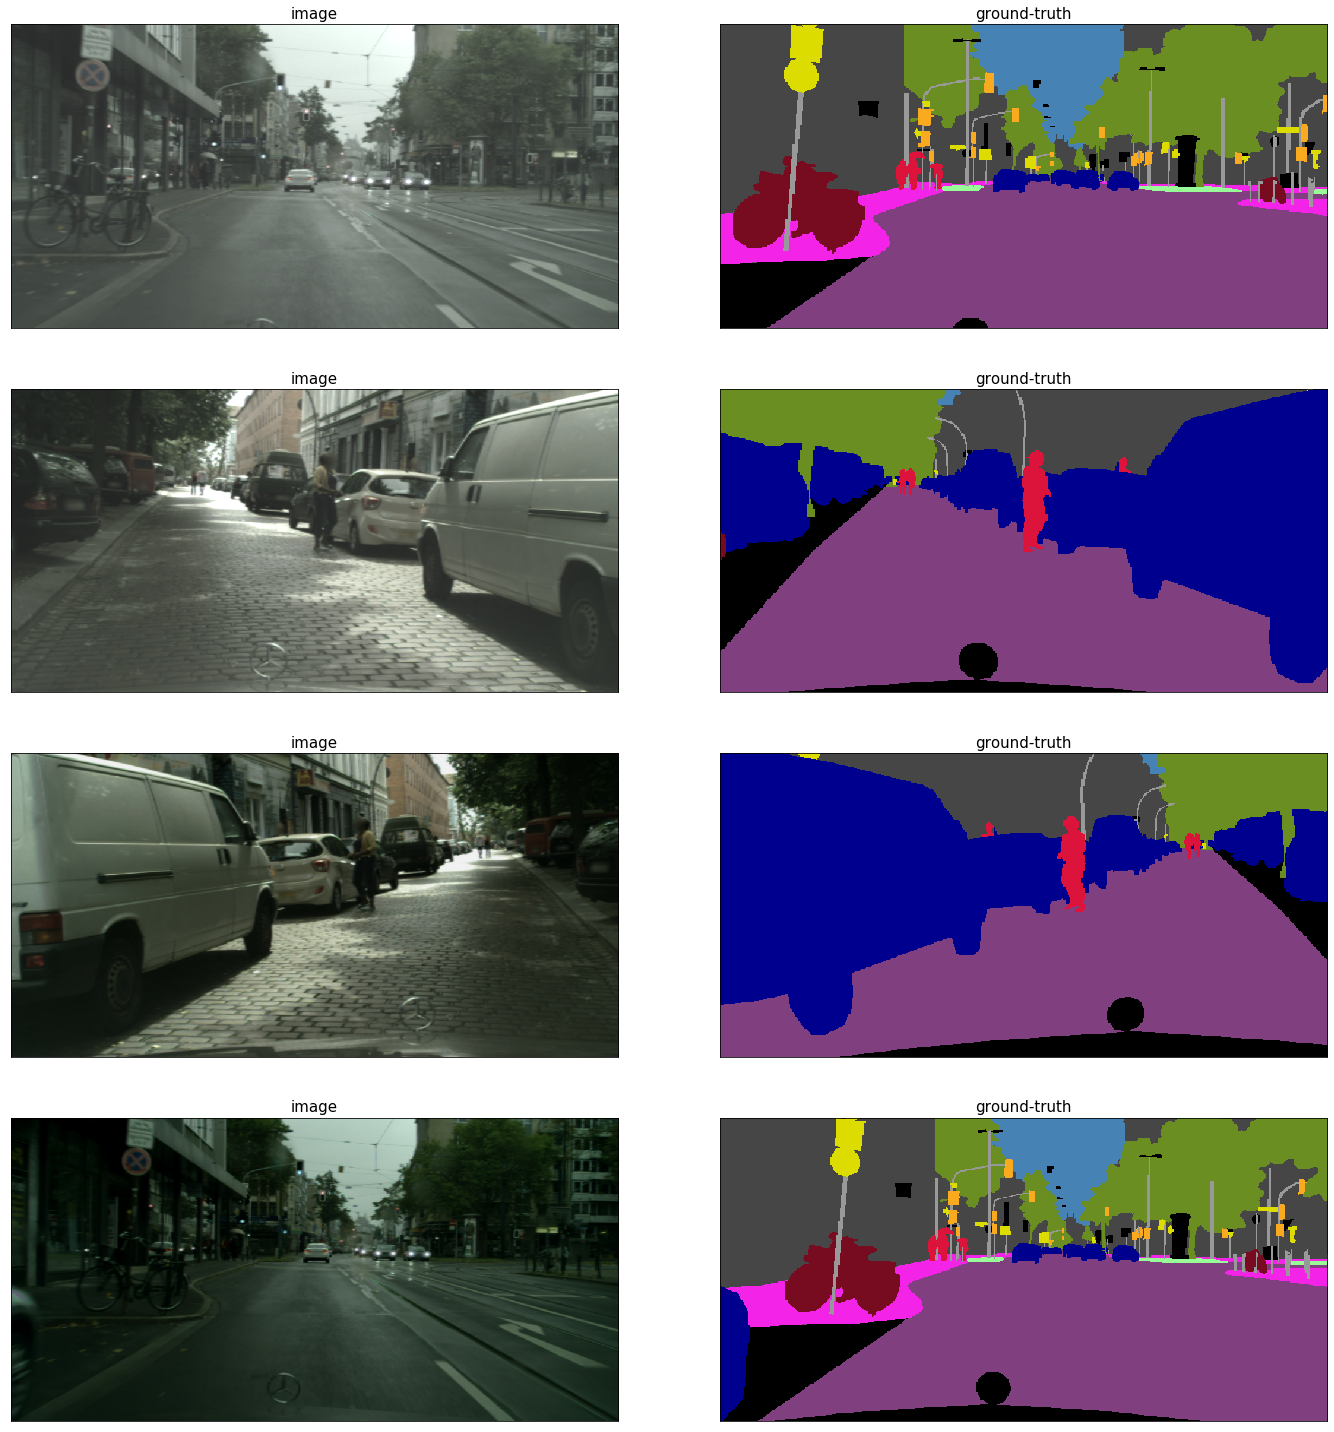

In [17]:
train_dataset_iter = train_dataset.__iter__()
train_images1, train_labels1 =  next(train_dataset_iter)
train_images2, train_labels2 =  next(train_dataset_iter)

train_images = np.concatenate((train_images1[:num_show], train_images2[:num_show]), axis=0)
train_labels = np.concatenate((train_labels1[:num_show], train_labels2[:num_show]), axis=0)

image_show, gt_show = postprocess_to_show(train_images, train_labels)
    
figure = plot_image_grid([image_show, gt_show], 
                         ["image", "ground-truth"])
figure.show()